In [1]:
from microcity.terrain import _make_random_heightmap

import matplotlib.pyplot as plt
import numpy as np

from functools import partial

import jax
import jax.numpy as jnp
import jax.scipy as jsp

import matplotlib.pyplot as plt
import numpy as np

In [2]:
width = 1024
heights = _make_random_heightmap((width, width))

In [3]:
# coordinates of our waypoints
coords = np.array([
    (200, 200), (400, 200), (600,600), (200, 800)
])

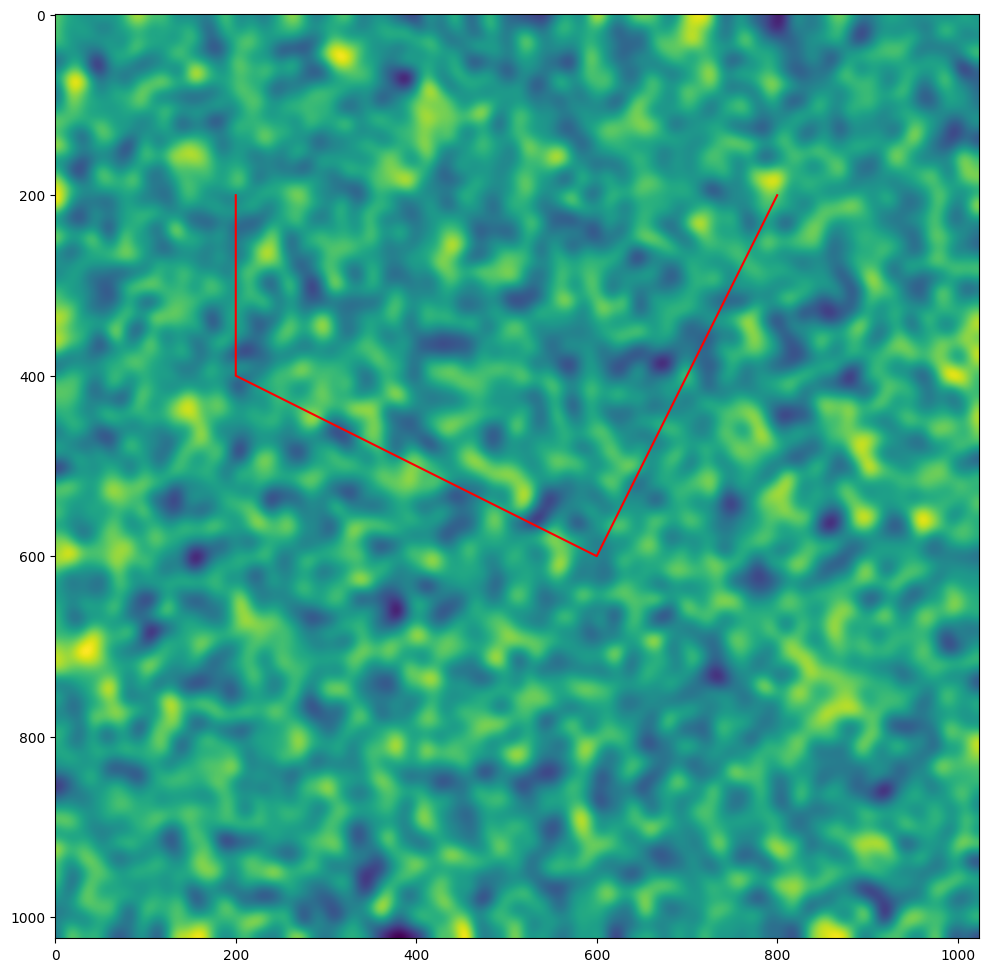

In [4]:
plt.figure(figsize=(12,12))
plt.imshow(heights)
plt.plot(coords[:, 1], coords[:, 0], 'r-')


In [5]:
def update_i(i, uu, slowness, bb):
    a = jnp.minimum(uu[i - 1], uu[i + 1])
    b = bb[i]
    
    w = jnp.abs(a - b) >= slowness[i]

    g = jnp.minimum(a, b) + slowness[i]
    h = (a + b + jnp.sqrt(2 * slowness[i] ** 2 - (a - b) ** 2)) / 2

    u_cand = jax.lax.select(w, g, h)

    u = jnp.minimum(u_cand, uu[i])
    return uu.at[i].set(u)


def sweep_lr(uu, uu0, uu1, slowness):
    # above and below
    bb = jnp.minimum(uu0, uu1)

    return jax.lax.fori_loop(
        1, width - 1, partial(update_i, bb=bb, slowness=slowness), uu
    )


def sweep_rl(uu, uu0, uu1, slowness):
    uu = jnp.flip(uu, axis=-1)
    uu0 = jnp.flip(uu0, axis=-1)
    uu1 = jnp.flip(uu1, axis=-1)
    slowness = jnp.flip(slowness, axis=-1)

    return jnp.flip(sweep_lr(uu, uu0, uu1, slowness), axis=-1)

@jax.jit
def one_iter(uu, slowness):
    width, height = uu.shape
    assert width == height

    def sc_sweep_lr(uu, row_idx):
        u = sweep_lr(uu[row_idx], uu[row_idx - 1], uu[row_idx + 1], slowness[row_idx])
        return uu.at[row_idx].set(u), None
    
    def sc_sweep_rl(uu, row_idx):
        u = sweep_rl(uu[row_idx], uu[row_idx - 1], uu[row_idx + 1], slowness[row_idx])
        return uu.at[row_idx].set(u), None

    uu = jax.lax.scan(sc_sweep_lr, uu, jnp.arange(1, width - 1))[0]
    uu = jax.lax.scan(sc_sweep_rl, uu, jnp.arange(1, width - 1))[0]
    uu = jax.lax.scan(sc_sweep_lr, uu, jnp.arange(width - 2, 0, -1))[0]
    uu = jax.lax.scan(sc_sweep_rl, uu, jnp.arange(width - 2, 0, -1))[0]

    return uu


def eikonal_solve(start_tt, slowness, num_iters):
    width, height = start_tt.shape
    assert width == height

    uu = start_tt.copy()

    for iter in range(num_iters):
        print(f"iter {iter:04d}", end="\r")

        uu = one_iter(uu, slowness)
    
    return uu

In [6]:
slowness = np.ones_like(heights)

start_val = 2 * width * jnp.max(slowness)

start_tt = jnp.full((width, width), start_val)
start_tt = start_tt.at[width // 2, width // 2].set(0.0)

In [7]:
uu = eikonal_solve(start_tt, slowness, 100)

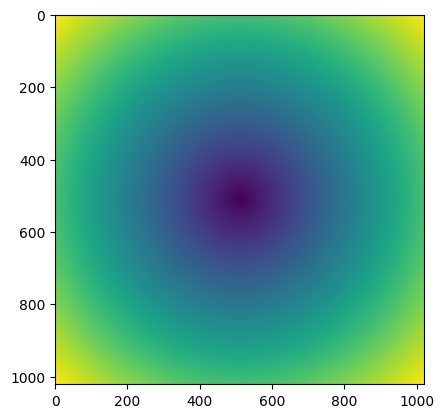

In [8]:
plt.imshow(uu[1:-1, 1:-1])

In [9]:
uu[0, 0]

Array(2048., dtype=float32)

In [10]:
uu[width // 2, width // 2]

Array(0., dtype=float32)